In [1]:
import networkx as nx
from glob import glob
import pdb
import re
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd; pd.options.display.float_format = '{:,.2f}'.format
import statsmodels.stats.api as sm
import warnings; warnings.filterwarnings("ignore", category=UserWarning)
from statistics import median_low

In [2]:
import sys
import os

sys.path.extend(['./..'])  # have to add the project path manually to the Python path
os.chdir('./..')

In [3]:
pwd

'/home/danielgonzalez/repos/infinity-mirror'

In [4]:
from src.utils import load_pickle
from src.Tree import TreeNode

In [5]:
%matplotlib inline

## Aggregate all the stats & make the plot

In [6]:
graphs = ['3-comm', 'BA-1000-3', 'BA-100-3', 'clique-ring-100-4', 'clique-ring-25-4', 'clique-ring-50-4', 'dolphins', 'eucore', 'flights', 'football', 'grid-100-100', 'grid-10-10', 'karate', 'ladder-10', 'ladder-100', 'ladder-20', 'la    dder-4', 'ladder-50', 'ladder-500', 'ring-10', 'ring-100', 'ring-1000', 'ring-20', 'ring-500']

models_3_comm = ['BTER', 'Chung-Lu', 'CNRG', 'Deep_GCN_AE', 'Deep_GCN_VAE', 'Erdos-Renyi', 'GCN_AE', 'GCN_VAE', 'GraphVAE', 'HRG', 'Linear_AE', 'Linear_VAE', 'NetGAN' 'SBM']
models_clique_ring_25_4 = ['BTER', 'Chung-Lu', 'CNRG', 'Erdos-Renyi', 'GraphAE', 'GraphVAE', 'HRG', 'NetGAN', 'SBM']
models_clique_ring_100_4 = ['BTER', 'Chung-Lu', 'CNRG', 'Erdos-Renyi', 'GraphAE', 'HRG', 'SBM']
models_dolphins = ['BTER', 'Chung-Lu', 'CNRG', 'Erdos-Renyi', 'GraphAE', 'GraphVAE', 'HRG', 'SBM']
models_karate = ['BTER', 'Chung-Lu', 'CNRG', 'Erdos-Renyi', 'GraphAE', 'GraphVAE', 'HRG', 'Kronecker', 'NetGAN']
models_ladder_50 = ['BTER', 'Chung-Lu', 'CNRG', 'Erdos-Renyi', 'GraphAE', 'GraphVAE', 'HRG', 'SBM']

In [7]:
base_path = '/home/danielgonzalez/repos/infinity-mirror/output/pickles'
models = models_ladder_50
graph = 'ladder-50'
sel = 'fast'

In [8]:
def get_stats_from_root(graph, model, sel, root, cols, trial_id):
    for tnode in root.descendants:
        row = {}
        row['graph'] = graph
        row['type'] = 'absolute'
        
        row['orig_n'] = root.graph.order()
        row['orig_m'] = root.graph.size()
        row['orig_graph_obj'] = root.graph
        
        row['model'] = model
        row['sel'] = sel
        row['trial_id'] = trial_id
        
        row['gen_id'] = tnode.depth
        row['gen_n'] = tnode.graph.order()
        row['gen_m'] = tnode.graph.size()
        row['gen_graph_obj'] = tnode.graph

        
        # use the stats compared with the original seed
        stats = tnode.stats
        assert set(cols[-8: ]) == set(stats.keys()), f'tnode: {stats.keys()} doesnt have all the reqd stats'
        for key, val in stats.items():
            row[key] = val
        
        assert len(row.keys()) == len(cols), \
            f'Improper number of cols in row: {len(row)}: expected {len(cols)} {stats.keys()}'
        
        yield row

    for tnode in root.descendants:
        row = {}
        row['graph'] = graph
        row['type'] = 'sequential'
        
        row['orig_n'] = root.graph.order()
        row['orig_m'] = root.graph.size()
        row['orig_graph_obj'] = root.graph
        
        row['model'] = model
        row['sel'] = sel
        row['trial_id'] = trial_id
        
        row['gen_id'] = tnode.depth
        row['gen_n'] = tnode.graph.order()
        row['gen_m'] = tnode.graph.size()
        row['gen_graph_obj'] = tnode.graph
        
        # use the stats compared with the previous graph
        stats = tnode.stats_seq
        assert set(cols[-8: ]) == set(stats.keys()), f'tnode: {stats.keys()} doesnt have all the reqd stats'
        for key, val in stats.items():
            row[key] = val
        
        assert len(row.keys()) == len(cols), \
            f'Improper number of cols in row: {len(row)}: expected {len(cols)} {stats.keys()}'
        
        yield row

In [9]:
cols = ['graph', 'type', 'orig_n', 'orig_m', 'orig_graph_obj', 
        'model', 'sel', 'trial_id',
        'gen_id', 'gen_n', 'gen_m', 'gen_graph_obj',
        'deltacon0', 'lambda_dist', 'degree_cvm', 'pagerank_cvm', 
        'pgd_pearson', 'pgd_spearman', 'node_diff', 'edge_diff']

data = {col: [] for col in cols}

for model in models:
    path = os.path.join(base_path, graph, model)
    for filename in os.listdir(path):
        if filename[5:7:1] == '20':
            trial_id = filename[8:10:1]
            try:
                trial_id = int(trial_id)
            except ValueError:
                trial_id = int(trial_id[:-1])
            root = load_pickle(os.path.join(path, filename))
            for row in get_stats_from_root(graph=graph, model=model, sel=sel, root=root, cols=cols, trial_id=trial_id):
                for col, val in row.items():
                    data[col].append(val)
            
df = pd.DataFrame(data)

In [10]:
df

,graph,type,orig_n,orig_m,orig_graph_obj,model,sel,trial_id,gen_id,gen_n,gen_m,gen_graph_obj,deltacon0,lambda_dist,degree_cvm,pagerank_cvm,pgd_pearson,pgd_spearman,node_diff,edge_diff
0,ladder-50,absolute,100,148,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",BTER,fast,20,1,100,147,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",832.50,0.09,0.25,0.37,inf,inf,0.00,1.00
1,ladder-50,absolute,100,148,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",BTER,fast,20,2,100,147,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",814.60,0.09,0.25,0.37,inf,inf,0.00,1.00
2,ladder-50,absolute,100,148,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",BTER,fast,20,3,100,144,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",747.24,0.10,0.23,0.37,inf,inf,0.00,4.00
3,ladder-50,absolute,100,148,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",BTER,fast,20,4,100,143,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",787.48,0.12,0.23,0.36,inf,inf,0.00,5.00
4,ladder-50,absolute,100,148,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",BTER,fast,20,5,100,143,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",711.38,0.12,0.23,0.38,inf,inf,0.00,5.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,ladder-50,sequential,100,148,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",SBM,fast,17,16,100,110,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",400.42,0.01,0.10,0.03,inf,inf,0.00,3.00
13996,ladder-50,sequential,100,148,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",SBM,fast,17,17,100,103,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",377.25,0.03,0.15,0.05,inf,inf,0.00,7.00
13997,ladder-50,sequential,100,148,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",SBM,fast,17,18,100,90,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",276.24,0.04,0.09,0.04,inf,inf,0.00,13.00
13998,ladder-50,sequential,100,148,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",SBM,fast,17,19,100,102,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",278.34,0.04,0.09,0.05,inf,inf,0.00,12.00


In [11]:
#df[(df.graph=='clique-ring-25-4') & (df.gen_id==5)].shape
plt.rcParams['figure.figsize'] = [40, 20]

In [12]:
def group_plot(df, graph_name):
    graph = df.graph.unique()[0]
    metrics = ['node_diff', 'edge_diff', 'lambda_dist', 'deltacon0', 'degree_cvm']#, 'pgd_spearman']
    models = df.model.unique()
    rows = len(metrics)
    cols = len(models)

    n_d_min = min(df[df.model==model].node_diff.min() for model in models) - 1
    n_d_max = max(df[df.model==model].node_diff.max() for model in models) + 5
    
    e_d_min = min(df[df.model==model].edge_diff.min() for model in models) - 1
    e_d_max = max(df[df.model==model].edge_diff.max() for model in models) + 5
    
    l_d_min = min(df[df.model==model].lambda_dist.min() for model in models) - 0.1
    l_d_max = max(df[df.model==model].lambda_dist.max() for model in models) + 0.15
    
    dc0_min = min(df[df.model==model].deltacon0.min() for model in models) - 100
    dc0_max = max(df[df.model==model].deltacon0.max() for model in models) + 100
    
    p_sp_min = min(df[df.model==model].pgd_spearman.min() for model in models) - 0.1
    p_sp_max = max(df[df.model==model].pgd_spearman.max() for model in models) + 0.15
    
    d_min = min(df[df.model==model].degree_cvm.min() for model in models) - 0.1
    d_max = max(df[df.model==model].degree_cvm.max() for model in models) + 0.15

    fig, axes = plt.subplots(nrows=rows, ncols=cols, sharex=True)
    print(rows, cols)

    for i in range(rows):
        for j in range(cols):
            ax = axes[i, j]
            metric = metrics[i]
            model = models[j]
            filtered_df = df[df.model==model]
            
            if i == 0 and j == 0:
                legend_style = 'brief'
            else:
                legend_style = ''
            
            sns.lineplot(x='gen_id', y=metric, ax=ax, data=filtered_df,
                         hue='type', marker='o', ci=99, err_style='band', legend=legend_style);

            if metric == 'node_diff':
                ax.set_ylim((n_d_min, n_d_max))
            elif metric == 'edge_diff':
                ax.set_ylim((e_d_min, e_d_max))
            elif metric == 'lambda_dist':
                ax.set_ylim((l_d_min, l_d_max))
            elif metric == 'deltacon0':
                ax.set_ylim((dc0_min, dc0_max))
            elif metric == 'pgd_spearman':
                ax.set_ylim((p_sp_min, p_sp_max))
            elif metric == 'degree_cvm':
                ax.set_ylim((d_min, d_max))
                
            if j == 0:
                ax.set_ylabel(metric)
            else:
                ax.set_ylabel('')
                
            if i == 0:
                ax.set_title(model)
            else:
                ax.set_title('')
                
            if i == rows - 1:
                ax.set_xlabel('gen_id')
            else:
                ax.set_xlabel('')
            
    plt.suptitle(f'{graph}', y=1.03);
    plt.tight_layout()
    plt.savefig(f'analysis/figures/{graph_name}.pdf', format='pdf', dpi=1000, bbox_inches='tight')

## plots

5 7


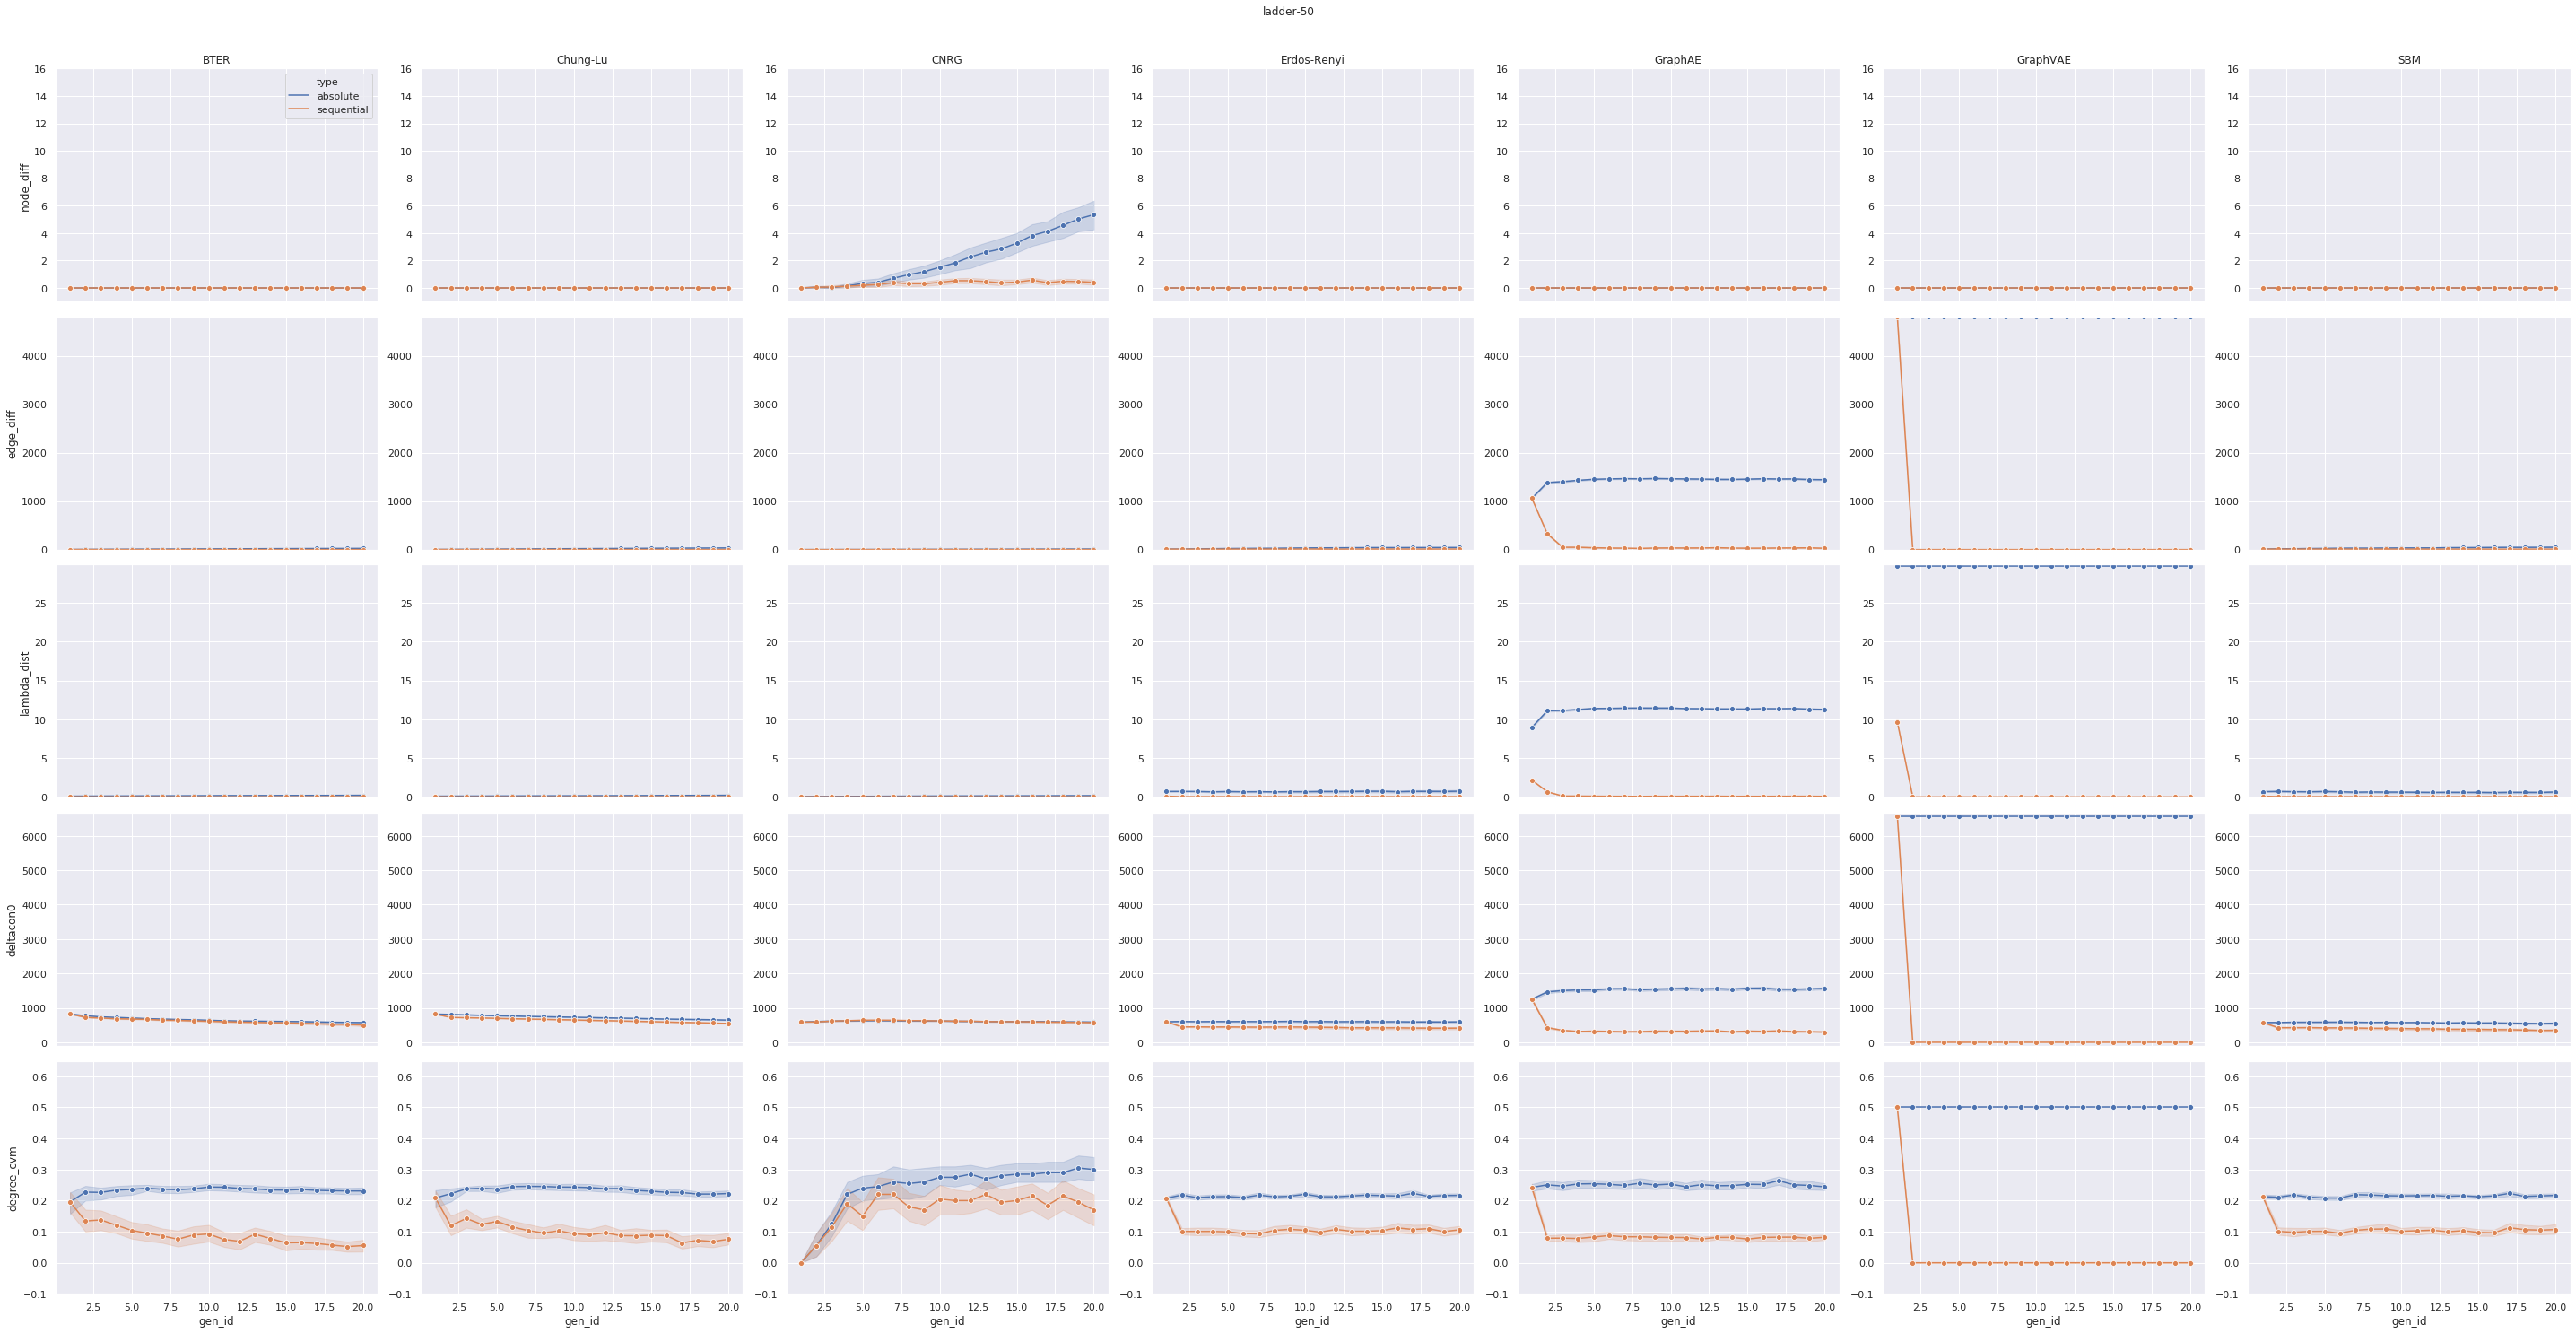

In [13]:
group_plot(df, graph)